# Quantum-enhanced telescopy: Marchese-Kok scheme

In [6]:
import functools

import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
import polars as pl
import tqdm
from rich.pretty import pprint

from squint.circuit import Circuit
from squint.ops.fock import LinearOpticalUnitaryGate, FockState, Phase
from squint.utils import print_nonzero_entries

In [ ]:
cut = 3
circuit = Circuit()

m = 2  # number of modes (m = 2 is equivalent to the GJC scheme)

# we add in the stellar photon, which is in an even superposition of spatial modes 0 and 2 (left and right telescopes)
for i in range(m):
    circuit.add(
        FockState(
            wires=(
                i,
                m + i,
            ),
            n=[(1 / jnp.sqrt(2).item(), (1, 0)), (1 / jnp.sqrt(2).item(), (0, 1))],
        )
    )

circuit.add(Phase(wires=(0,), phi=0.01), "phase")
circuit.add(LinearOpticalUnitaryGate(wires=tuple(range(0, m)), rs=jnp.ones(m * (m - 1) // 2) * 0.1))
circuit.add(LinearOpticalUnitaryGate(wires=tuple(range(m, 2 * m)), rs=jnp.ones(m * (m - 1) // 2) * 0.1))
pprint(circuit)

Circuit(
  dims=None,
  ops={
│   0:
│   FockState(
│     wires=(0, 2),
│     n=[(0.7071067811865476, (1, 0)), (0.7071067811865476, (0, 1))]
│   ),
│   1:
│   FockState(
│     wires=(1, 3),
│     n=[(0.7071067811865476, (1, 0)), (0.7071067811865476, (0, 1))]
│   ),
│   'phase':
│   Phase(wires=(0,), phi=weak_f64[]),
│   3:
│   LinearOpticalUnitaryGate(wires=(0, 1), rs=f64[1]),
│   4:
│   LinearOpticalUnitaryGate(wires=(2, 3), rs=f64[1])
  },
  _backend=None
)

In [8]:
# we split out the params which can be varied (in this example, it is just the "phase" phi value), and all the static parameters (wires, etc.)
# params, static = partition_op(circuit, "phase")
params, static = eqx.partition(circuit, eqx.is_inexact_array)
sim = circuit.compile(params, static, dim=cut, optimize="greedy").jit()
get = lambda pytree: jnp.array([pytree.ops["phase"].phi])

In [9]:
ket = sim.amplitudes.grad(params)
prob = sim.probabilities.forward(params)
grad = sim.probabilities.grad(params)

print_nonzero_entries(prob)

Basis: [0 0 0 2], Value: 0.004933686461299658
Basis: [0 0 1 1], Value: 0.24013260006904602
Basis: [0 0 2 0], Value: 0.004933686461299658
Basis: [0 1 0 1], Value: 0.009867127053439617
Basis: [0 1 1 0], Value: 0.2401328682899475
Basis: [0 2 0 0], Value: 0.00493368785828352
Basis: [1 0 0 1], Value: 0.2401328682899475
Basis: [1 0 1 0], Value: 0.009867127984762192
Basis: [1 1 0 0], Value: 0.24013257026672363
Basis: [2 0 0 0], Value: 0.00493368785828352


In [10]:
# %% Differentiate with respect to parameters of interest
def _loss_fn(params, sim, get):
    return sim.probabilities.cfim(get, params).squeeze()


loss_fn = functools.partial(_loss_fn, sim=sim, get=get)
print(f"Classical Fisher information of starting parameterization is {loss_fn(params)}")

# %%
start_learning_rate = 1e-2
optimizer = optax.chain(optax.adam(start_learning_rate), optax.scale(-1.0))
opt_state = optimizer.init(params)

Classical Fisher information of starting parameterization is 5.136369833470491e-07


Training: 100%|██████████| 300/300 [00:05<00:00, 57.02it/s, loss=0.4999998838720263]   
/var/folders/fk/gsbw4p3n6wxb9cs3bj47j0p00000gn/T/ipykernel_46891/2329134787.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Basis: [0 0 0 2], Value: 0.12499997764825821
Basis: [0 0 1 1], Value: 6.814096812843284e-14
Basis: [0 0 2 0], Value: 0.12499997764825821
Basis: [0 1 0 1], Value: 0.20570361614227295
Basis: [0 1 1 0], Value: 0.044296395033597946
Basis: [0 2 0 0], Value: 0.1249999925494194
Basis: [1 0 0 1], Value: 0.044296395033597946
Basis: [1 0 1 0], Value: 0.20570361614227295
Basis: [1 1 0 0], Value: 6.008966246676475e-14
Basis: [2 0 0 0], Value: 0.1249999925494194
Circuit(
  dims=None,
  ops={
    0:
    FockState(
      wires=(None, None),
      n=[(None, (None, None)), (None, (None, None))]
    ),
    1:
    FockState(
      wires=(None, None),
      n=[(None, (None, None)), (None, (None, None))]
    ),
    'phase':
    Phase(wires=(None,), phi=Array(0.86894994, dtype=float64)),
    3:
    LinearOpticalUnitaryGate(
      wires=(None, None),
      rs=Array([0.78539792], dtype=float64)
    ),
    4:
    LinearOpticalUnitaryGate(
      wires=(None, None),
      rs=Array([0.7853979], dtype=float64)
   

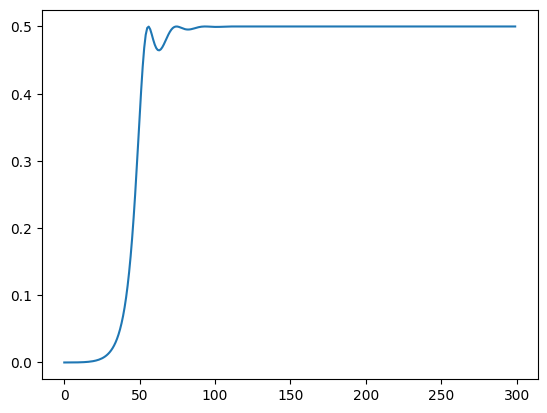

In [11]:
# %%
@jax.jit
def update(_params, _opt_state):
    _val, _grad = jax.value_and_grad(loss_fn)(_params)
    _updates, _opt_state = optimizer.update(_grad, _opt_state)
    _params = optax.apply_updates(_params, _updates)
    return _params, _opt_state, _val


# %%
df = []
update(params, opt_state)
n_steps = 300
pbar = tqdm.tqdm(range(n_steps), desc="Training", unit="it")
for step in pbar:
    params, opt_state, val = update(params, opt_state)

    pbar.set_postfix({"loss": val})
    pbar.update(1)

    df.append({"cfim": val, "step": step})

df = pl.DataFrame(df)

# %%
fig, ax = plt.subplots()
ax.plot(df["step"], df["cfim"])
fig.show()

# %%
prob = sim.probabilities.forward(params)
print_nonzero_entries(prob)
eqx.tree_pprint(params, short_arrays=False)